# Pelatihan Model Analisis Sentimen (Model Training)

Notebook ini mengambil data bersih (`dataset_crithit_clean.csv`) dan melatih "otak" kecerdasan buatan untuk membedakan ulasan Positif dan Negatif.

**Fitur Utama:**
1. **Rating-Based Labeling:** Menggunakan Bintang 1-5 sebagai *Ground Truth*.
2. **Smart Balancing:** Menyeimbangkan jumlah data Positif dan Negatif agar model adil.
3. **Advanced Negation Handling:** Teknik khusus mengubah "Tidak Bagus" menjadi "Buruk" (Antonim).
4. **TF-IDF Vectorization:** Mengubah kata menjadi angka.
5. **Evaluasi:** Mengukur akurasi dengan Confusion Matrix.

---


## 1. Import Library

In [ ]:
import pandas as pd
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [ ]:
# Setup Engine Preprocessing (Diperlukan untuk handle negasi)
negation_words = {'tidak', 'gak', 'ga', 'gk', 'bukan', 'jangan', 'enggak', 'tak', 'jan'}
all_stopwords = set(stop_factory.get_stop_words()) - negation_words 

print("Library Siap!")

Library Siap!


## 2. Advanced Negation Handling (Logika Cerdas)
Ini adalah trik agar model lebih paham konteks. Kita menggunakan **Kamus Antonim**.
* Jika ketemu "tidak bagus" -> diubah jadi "buruk".
* Jika ketemu "jangan download" -> diubah jadi "hindari".

In [41]:
# --- KAMUS ANTONIM ---
antonym_map = {
    # Positif -> Negatif (Jika didahului kata 'tidak')
    'bagus': 'buruk',
    'baik': 'jahat',
    'suka': 'benci',
    'puas': 'kecewa',
    'senang': 'sedih',
    'seru': 'membosankan',
    'keren': 'jelek',
    'epik': 'biasa',
    'worth': 'rugi',
    'layak': 'rugi',
    'ramah': 'jutek',
    'stabil': 'lag',
    'lancar': 'macet',
    'cepat': 'lambat',
    'pro': 'noob',
    'gg': 'noob',
    'wangi': 'ampas',
    'hoki': 'sial',
    'adil': 'curang',
    'bersih': 'kotor',
    'murah': 'mahal',
    'download': 'hindari',
    'main': 'hindari',
    
    # Negatif -> Positif (Jika didahului kata 'tidak')
    'buruk': 'bagus',
    'jelek': 'bagus',
    'kacau': 'rapi',
    'rusak': 'normal',
    'gagal': 'berhasil',
    'benci': 'suka',
    'kesal': 'senang',
    'bosan': 'seru',
    'susah': 'mudah',
    'ribet': 'mudah',
    'parah': 'bagus',
    'kecewa': 'puas',
    'nyesel': 'puas',
    'sial': 'beruntung',
    'mahal': 'murah',
    'pelit': 'baik',
    'curang': 'adil',
    'lag': 'lancar',
    'lemot': 'cepat',
    'berat': 'ringan',
    'patah': 'lancar',
    'ampas': 'wangi',
    'bug': 'lancar',
    'error': 'normal'
}

# --- FUNGSI PENANGANAN NEGASI BARU (ANTONYM REPLACEMENT) ---
def handle_negation_advanced(text):
    words = text.split()
    new_words = []
    
    skip_next = False
    
    for i, w in enumerate(words):
        if skip_next:
            skip_next = False
            continue
            
        # Cek apakah kata sekarang adalah NEGASI
        if w in negation_words and i + 1 < len(words):
            next_word = words[i+1]
            
            # Cek apakah kata depannya punya lawan kata di kamus?
            if next_word in antonym_map:
                # REPLACE: Ganti "tidak bagus" menjadi "buruk"
                replacement = antonym_map[next_word]
                new_words.append(replacement)
                skip_next = True # Kita lompati kata 'bagus' karena sudah diganti
            else:
                # Jika tidak ada di kamus, pakai cara lama (gabung pakai underscore)
                # Contoh: "tidak makan" -> "tidak_makan"
                new_token = f"{w}_{next_word}"
                new_words.append(new_token)
                skip_next = True
        else:
            new_words.append(w)
            
    return " ".join(new_words)

## 3. Persiapan Data Training
Kita akan memuat data, melakukan labeling berdasarkan rating, dan menyeimbangkan data.

**Logika Labeling:**
* Bintang 4-5 = **Positif (1)**
* Bintang 1-2 = **Negatif (0)**
* Bintang 3 = **Netral (Dibuang)**

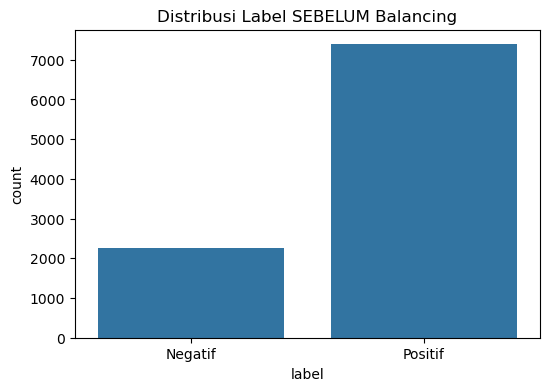

Melakukan Balancing Data...
Total Data Training: 14774 baris (Seimbang).


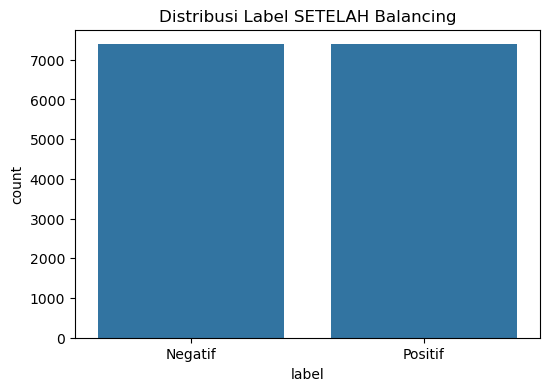

In [42]:
# 1. Load Data
df = pd.read_csv('dataset_crithit_clean.csv')
df = df.dropna(subset=['text_final'])

# 2. Labeling
df = df[df['score'] != 3].copy()
df['label'] = df['score'].apply(lambda x: 1 if x > 3 else 0)

# Visualisasi Ketimpangan Data Sebelum Balancing
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Distribusi Label SEBELUM Balancing")
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.show()

# 3. Balancing (Oversampling)
print("Melakukan Balancing Data...")
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# Samakan jumlah data dengan kelas terbanyak
target_count = max(len(df_pos), len(df_neg))
minority = df_neg if len(df_neg) < len(df_pos) else df_pos
majority = df_pos if len(df_neg) < len(df_pos) else df_neg

minority_upsampled = resample(minority, replace=True, n_samples=target_count, random_state=42)
df_balanced = pd.concat([majority, minority_upsampled])

print(f"Total Data Training: {len(df_balanced)} baris (Seimbang).")

# Visualisasi Setelah Balancing
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_balanced)
plt.title("Distribusi Label SETELAH Balancing")
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.show()

## 4. Training Model
Kita menggunakan algoritma **Logistic Regression** yang dipadukan dengan **TF-IDF** (Term Frequency-Inverse Document Frequency).

> **Info:** Logistic Regression dipilih karena ringan, cepat, dan sangat efektif untuk data teks (NLP) dengan ukuran yang kecil.

In [43]:
# Apply Preprocessing Final (Untuk Negasi)
print("Menerapkan Final Preprocessing...")
df_balanced['text_train'] = df_balanced['text_final'].apply(handle_negation_advanced)

# Split Data (80% Latihan, 20% Ujian)
X_train, X_test, y_train, y_test = train_test_split(df_balanced['text_train'], df_balanced['label'], test_size=0.2, random_state=42)

# Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Model Training
print("Melatih Model...")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_vec, y_train)
print("Selesai!")

Menerapkan Final Preprocessing...
Melatih Model...
Selesai!


## 5. Evaluasi Performa
Seberapa pintar model kita? Kita lihat menggunakan **Confusion Matrix**.

Akurasi Model: 88.39%


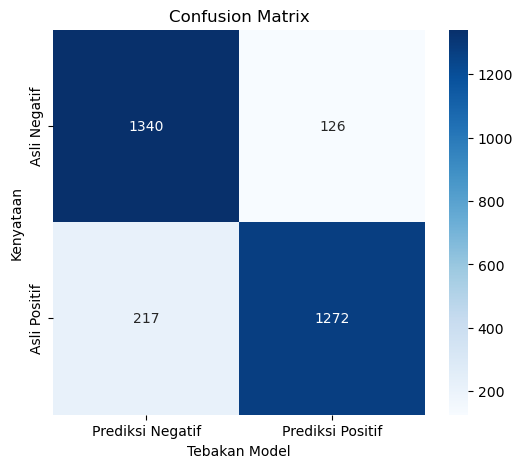


Detail Laporan:
              precision    recall  f1-score   support

     Negatif       0.86      0.91      0.89      1466
     Positif       0.91      0.85      0.88      1489

    accuracy                           0.88      2955
   macro avg       0.89      0.88      0.88      2955
weighted avg       0.89      0.88      0.88      2955



In [44]:
# Prediksi Data Test
y_pred = model.predict(X_test_vec)

# Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {acc*100:.2f}%")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Prediksi Negatif', 'Prediksi Positif'], yticklabels=['Asli Negatif', 'Asli Positif'])
plt.ylabel('Kenyataan')
plt.xlabel('Tebakan Model')
plt.title('Confusion Matrix')
plt.show()

print("\nDetail Laporan:")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif']))

## 6. Simpan Model untuk Produksi
Model yang sudah pintar ini kita save menjadi file `.pkl` agar bisa dipasang di website.

In [ ]:
MODEL_OUTPUT = '../ml_engine/crithit_model.pkl'
VECTORIZER_OUTPUT = '../ml_engine/crithit_vectorizer.pkl'

joblib.dump(model, MODEL_OUTPUT)
joblib.dump(tfidf, VECTORIZER_OUTPUT)

print(f"Model disimpan ke: {MODEL_OUTPUT}")
print(f"Vectorizer disimpan ke: {VECTORIZER_OUTPUT}")
print("Siap untuk deployment!")

Model disimpan ke: crithit_model.pkl
Vectorizer disimpan ke: crithit_vectorizer.pkl
Siap untuk deployment!
